In [1]:
#import deleteResults
#import postProcessing

In [2]:
import numpy

import analysis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
from analysisCounter import AnalysisCounter

counter_dict = analysis.get_counters()
rank_list = list(filter((-1).__ne__, analysis.get_rank_list()))
rank_table = pd.DataFrame(rank_list, columns=['Rank'])

In order to figure out appropriate buckets to sort results according to rank,
we display the total list of successfully ranked websites in a histogram
with relatively narrow buckets.

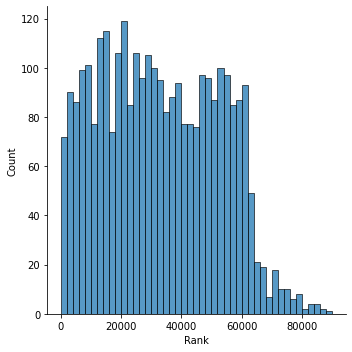

In [4]:
# Distribution of ranks in buckets of width=2000.
# This shows ranks > 60000 are underrepresented in dataset
sns.displot(rank_table, x='Rank', binwidth=2000)

From this graph we can see there is a drop-off roughly after 60000.
Because of this we only examine links up to that rank
in the graphs that divide results by rank.

In [5]:
def get_top_table(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    counter_df = pd.DataFrame.from_dict(counter.total, orient='index', columns=['Count'])
    counter_df.index.name = index_name
    counter_data = counter_df.nlargest(n=n, columns=['Count'])
    return counter_data.to_latex()

In [34]:
def get_bucket_size_table(counter: AnalysisCounter, latex = False):
    output = ''

    prefix = '\\begin{tabular}{lr}\n\\toprule\n' if latex else ''
    table_title = 'Bucket &  Count \\\\ \n\\midrule\n' if latex else ''
    line_divider = '\t&' if latex else ''
    line_end = '\\\\ \n' if latex else '\n'
    suffix = '\\bottomrule\n\\end{tabular}' if latex else ''

    output += prefix
    output += table_title
    for rank_bucket in counter.rank_buckets.keys():
        output += f'\t{rank_bucket}:{line_divider} \t{counter.rank_entries[rank_bucket]} {line_end}'
    output += suffix

    return output

In [6]:
def get_rank_plot(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    counter_df = pd.DataFrame(counter.rank)
    counter_df.insert(0, 'Total', 0)
    for key in counter.total.keys():
        try:
            counter_df.at[key, 'Total'] = counter.total[key]
        except KeyError:
            continue

    bucket_cols = list(domain_counter.rank_buckets.keys())
    for bucket in bucket_cols:
        counter_df[bucket] = counter_df[bucket].div(counter.rank_entries[bucket], axis=0).multiply(100)
    counter_df['Total'] = counter_df['Total'].div(counter.total_entries, axis=0).multiply(100)

    counter_data = counter_df.nlargest(n=n, columns=['Total'])[bucket_cols]
    counter_data.index.name = index_name
    counter_data.reset_index(inplace=True)

    counter_data_long = counter_data.melt(id_vars=index_name, var_name='rank', value_name='percentage')
    return sns.catplot(data=counter_data_long, kind='swarm', x='rank', y='percentage', hue=index_name)

In [7]:
def get_cmp_plot(counter: AnalysisCounter, n: int = 10, index_name: str = 'index'):
    counter_df = pd.DataFrame(counter.consent)
    counter_df.insert(0, 'Total', 0)
    for key in counter.total.keys():
        try:
            counter_df.at[key, 'Total'] = counter.total[key]
        except KeyError:
            continue

    counter_df['cmp'] = counter_df['cmp'].div(counter.cmp_entries, axis=0).multiply(100)
    counter_df['no-cmp'] = counter_df['no-cmp'].div(counter.no_cmp_entries, axis=0).multiply(100)
    counter_df['Total'] = counter_df['Total'].div(counter.total_entries, axis=0).multiply(100)

    counter_data = counter_df.nlargest(n=n, columns=['Total'])
    del counter_data['Total']
    counter_data.index.name = index_name
    counter_data.reset_index(inplace=True)
    counter_data_long = counter_data.melt(id_vars=index_name, var_name='consent', value_name='percentage')
    plot = sns.catplot(data=counter_data_long, kind='bar', x=index_name, y='percentage', hue='consent')
    new_label = [f'cmp\nn={counter.cmp_entries}', f'no-cmp\nn={counter.no_cmp_entries}']
    for t, l in zip(plot.legend.texts, new_label):
        t.set_text(l)
    return plot


In [8]:
domain_counter = counter_dict['domain']
amount_counter = counter_dict['total']
organisation_counter = counter_dict['organisation']
cmp_counter = counter_dict['cmp']
sns.set_theme()

## Amount of leakages per website

The following text covers the total number of pages that
circumvent a strict referrer policy at least once.

In [24]:
print(f'Total number of websites with at least 1 circumvention:\n\t{amount_counter.total_entries}\n')
print(f'Split by rank:')
for bucket in amount_counter.rank_buckets.keys():
    print(f'\t{bucket}: \t{amount_counter.rank_entries[bucket]}')
print(f'\nSplit by CMP:')
print(f'\tCMP:\t{amount_counter.cmp_entries}')
print(f'\tNo CMP:\t{amount_counter.no_cmp_entries}')

Total number of websites with at least 1 circumvention:
	2940

Split by bucket:
	1-12000: 	391
	12001-24000: 	487
	24001-36000: 	504
	36001-48000: 	433
	48001-60000: 	491
	>60000: 	225

Split by CMP:
	CMP:	436
	No CMP:	2504


## Domains being leaked to
The following graphs and text consider the domains to which URLs get leaked.
The data only considers cases where a strict referrer policy is circumvented.

In [25]:
print(f'Total number of websites being leaked from: \t{domain_counter.total_entries}\n'
      f'Total number of domains being leaked to: \t{len(domain_counter.total)}\n')

table_size=10
print(f'LaTeX table displaying the top {table_size} domains being leaked to:')
print(get_top_table(domain_counter, n=table_size, index_name='Domains'))

Total number of websites being leaked from: 	2940
Total number of domains being leaked to: 	1077

LaTeX table displaying the top 10 domains being leaked to:
\begin{tabular}{lr}
\toprule
{} &  Count \\
Domains               &        \\
\midrule
google-analytics.com  &   2518 \\
facebook.com          &   1679 \\
doubleclick.net       &   1521 \\
google.com            &   1436 \\
google.nl             &   1302 \\
bing.com              &    860 \\
pinterest.com         &    603 \\
nr-data.net           &    371 \\
twitter.com           &    303 \\
googlesyndication.com &    271 \\
\bottomrule
\end{tabular}



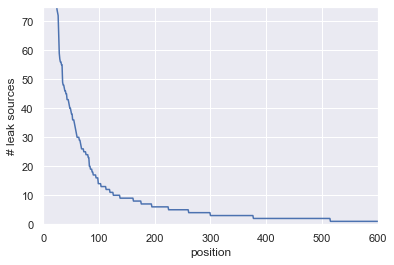

In [13]:
domain_df = pd.DataFrame.from_dict(data=domain_counter.total, orient='index', columns=['# leak sources'])
domain_df.sort_values(inplace=True, ascending=False, by='# leak sources')
domain_df.reset_index(inplace=True)
del domain_df['index']
domain_df.index.name = 'position'
g = sns.lineplot(data=domain_df, y='# leak sources', x='position')
_ = plt.axis([0,600,0,75])

In this plot we see a sorted list of all domains being leaked to.
The list is sorted by the number of websites leaking to each domain.

We see that roughly less than 375 domains get leaked to more than twice.
Roughly 125 domains get leaked to more than 10 times.

Rank bucket sizes:
	1-12000: 	391 
	12001-24000: 	487 
	24001-36000: 	504 
	36001-48000: 	433 
	48001-60000: 	491 
	>60000: 	225 



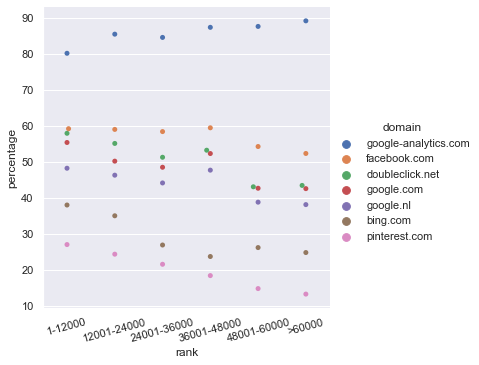

In [38]:
domain_rank_plot = get_rank_plot(domain_counter, n=7, index_name='domain')
_ = plt.xticks(rotation=15)
print('Rank bucket sizes:')
print(get_bucket_size_table(domain_counter))

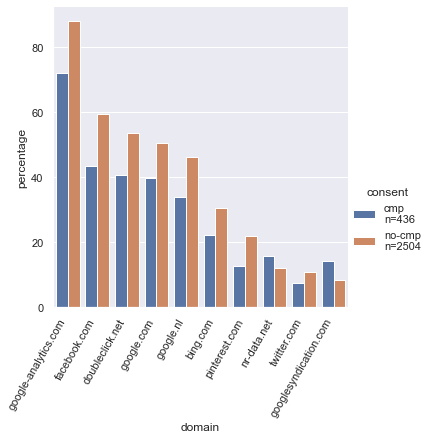

In [15]:
domain_cmp_plot = get_cmp_plot(domain_counter, index_name='domain')
_ = plt.xticks(rotation=60, ha='right')

## Organisations

The following text and graphs show the leakages to specific organisations,
which may own multiple domains.

For example leakages to ```google-analytics.com``` and ```doubleclick.net```
are both considered leakages to Google LLC.

In [16]:
print(f'Total number of known organisations being leaked to:\t {len(organisation_counter.total)}\n'
      f'Number of websites leaking to these organisations:\t {organisation_counter.total_entries}')

Total number of known organisations being leaked to:	 420
Number of websites leaking to these organisations:	 2905


Rank bucket sizes:
	1-12000: 	382 
	12001-24000: 	485 
	24001-36000: 	498 
	36001-48000: 	428 
	48001-60000: 	485 
	>60000: 	222 



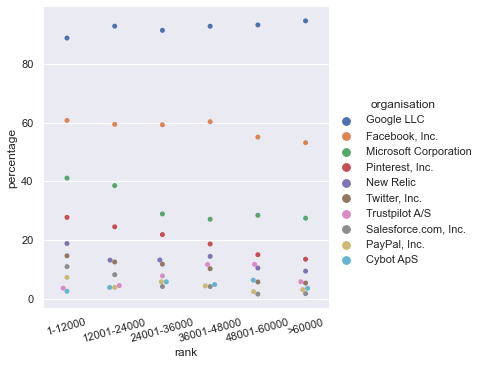

In [39]:
organisation_rank_plot = get_rank_plot(organisation_counter, n=10, index_name='organisation')
_ = plt.xticks(rotation=15)

print('Rank bucket sizes:')
print(get_bucket_size_table(organisation_counter))

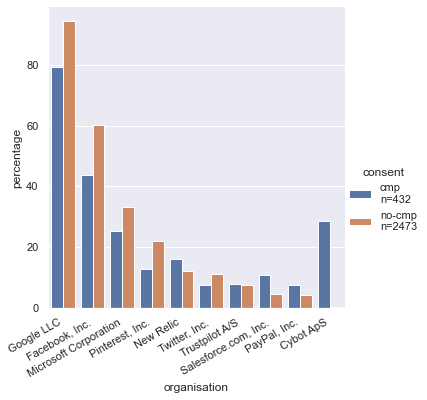

In [18]:
organisation_cmp_plot = get_cmp_plot(organisation_counter, index_name='organisation')
_ = plt.xticks(rotation=30, ha='right')

In [19]:
cmp_df = pd.DataFrame.from_dict(cmp_counter.total, orient='index', columns=['Amount'])
cmp_df.sort_values(inplace=True, ascending=False, by='Amount')
cmp_df.iloc[1:]

,Amount
cookiebot,125
onetrust1,39
cookiebar,26
optanon,19
trustarcbar,16
cookieinformation,12
didomi.io,10
ez-cookie,4
consentmanager.net,4
tealium.com,4
